In [114]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from LEN_Scorer import Scorer
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans


In [83]:
mimicDF = pd.read_csv('../LEN_Test/data/StaticData.csv')
targetDF = mimicDF[['deathperiod']]
mimicDF = mimicDF.drop(columns=['PatientID', 'deathperiod'])

categorisationTypes = {}

In [84]:
mimicDF.head()

,los,gender,age,comorbidity,sofa,respiration,coagulation,liver,renal,cardiovascular,cns
0,9,1,74.19,7,7,0.0,1.0,NaN,0.0,3.0,3.0
1,2,0,75.00,4,2,NaN,0.0,0.0,1.0,NaN,1.0
2,16,0,51.92,4,2,NaN,0.0,NaN,0.0,NaN,2.0
3,12,0,51.73,-13,4,2.0,2.0,NaN,0.0,NaN,0.0
4,7,0,62.07,0,3,0.0,2.0,NaN,1.0,NaN,0.0


In [85]:
mimicDF.describe()

,los,gender,age,comorbidity,sofa,respiration,coagulation,liver,renal,cardiovascular,cns
count,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000,3311.000000,5227.000000,2254.000000,5261.000000,1294.000000,5212.000000
mean,14.668757,0.382554,75.049002,9.801026,4.794185,1.987315,0.674957,0.696983,1.017297,3.238022,0.768611
std,14.101457,0.486057,50.553676,9.671438,2.694694,1.374066,0.892066,1.051290,1.263514,0.706116,1.140061
min,1.000000,0.000000,16.010000,-16.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,55.410000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,10.000000,0.000000,68.300000,9.000000,4.000000,2.000000,0.000000,0.000000,1.000000,3.000000,0.000000
75%,18.000000,1.000000,78.525000,16.000000,6.000000,3.000000,1.000000,1.000000,2.000000,4.000000,1.000000
max,202.000000,1.000000,306.880000,47.000000,22.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


In [86]:
rowsWithNaN = sum(mimicDF.isnull().any(axis=1))
print(f"{mimicDF.shape[0]} rows in df, {rowsWithNaN} containing NaN values")

5262 rows in df, 4778 containing NaN values


In [87]:
for col in mimicDF:
    mimicDF[col] = mimicDF[col].fillna(mimicDF[col].mode()[0])

In [88]:
mimicDF['respiration'].mode()[0]

3.0

In [89]:
mimicDF

,los,gender,age,comorbidity,sofa,respiration,coagulation,liver,renal,cardiovascular,cns
0,9,1,74.19,7,7,0.0,1.0,0.0,0.0,3.0,3.0
1,2,0,75.00,4,2,3.0,0.0,0.0,1.0,3.0,1.0
2,16,0,51.92,4,2,3.0,0.0,0.0,0.0,3.0,2.0
3,12,0,51.73,-13,4,2.0,2.0,0.0,0.0,3.0,0.0
4,7,0,62.07,0,3,0.0,2.0,0.0,1.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
5257,120,1,36.61,5,10,3.0,3.0,4.0,0.0,3.0,0.0
5258,13,0,53.90,12,4,3.0,0.0,0.0,0.0,3.0,1.0
5259,4,0,58.93,18,5,3.0,1.0,0.0,4.0,3.0,0.0
5260,16,0,68.98,-4,3,1.0,2.0,0.0,0.0,3.0,0.0


In [90]:
for i in range(len(mimicDF['sofa'])):
    print(mimicDF['sofa'][i])

7
2
2
4
3
7
4
14
8
9
6
5
2
4
2
9
6
3
7
2
3
5
4
6
4
13
2
3
5
4
5
7
4
2
2
2
3
6
2
10
7
4
7
6
7
5
2
10
9
2
6
4
6
4
2
4
3
2
4
4
3
8
3
7
9
4
7
2
12
7
5
4
7
4
10
12
7
3
3
6
5
10
7
3
4
2
6
2
5
6
2
2
7
3
2
10
2
5
9
5
2
8
5
10
3
2
2
3
4
6
2
3
5
9
5
3
2
2
2
4
2
4
2
6
3
7
3
3
5
2
2
3
16
5
2
9
5
4
3
7
11
3
3
4
2
8
5
5
2
4
7
10
8
14
3
9
5
4
5
3
3
3
4
7
4
4
2
7
3
4
12
2
2
2
4
2
7
4
5
5
4
3
3
9
3
3
6
5
4
4
3
5
5
3
2
8
11
8
2
2
7
2
3
3
4
5
4
8
3
6
6
5
2
5
2
7
3
8
11
2
3
9
7
5
4
7
3
2
5
6
2
9
8
2
7
6
3
11
10
3
5
5
8
6
2
2
2
5
6
3
11
3
3
9
6
2
7
8
4
4
2
5
7
3
3
2
3
6
5
2
7
5
3
2
4
2
2
4
4
4
3
4
3
9
6
6
2
9
4
7
4
3
2
9
3
2
4
5
4
3
2
2
8
3
14
11
5
9
18
5
2
2
3
2
4
3
4
3
4
4
2
3
3
11
2
3
3
2
5
2
8
5
2
9
2
2
9
4
5
4
4
3
2
10
3
3
5
4
5
3
4
3
11
4
3
6
9
4
5
7
5
2
3
4
8
7
2
2
3
3
4
3
10
7
4
9
2
11
5
4
3
14
7
12
3
6
3
8
7
2
3
5
8
4
6
4
3
6
8
7
2
3
5
4
6
8
3
4
12
18
2
5
3
12
9
6
6
6
5
4
2
5
4
6
2
2
4
5
2
5
9
2
4
4
5
4
6
14
3
2
4
4
2
5
2
8
4
3
4
7
10
2
4
3
3
9
11
3
4
7
3
7
5
3
8
3
9
3
5
4
3
4
2
4
3
3
4
2
6
5
4
8


In [91]:
mimicDF.describe()

,los,gender,age,comorbidity,sofa,respiration,coagulation,liver,renal,cardiovascular,cns
count,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000,5262.00000,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000
mean,14.668757,0.382554,75.049002,9.801026,4.794185,2.36279,0.670468,0.298556,1.017104,3.058533,0.761307
std,14.101457,0.486057,50.553676,9.671438,2.694694,1.19465,0.890785,0.769595,1.263472,0.364759,1.137079
min,1.000000,0.000000,16.010000,-16.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,55.410000,2.000000,3.000000,2.00000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,10.000000,0.000000,68.300000,9.000000,4.000000,3.00000,0.000000,0.000000,1.000000,3.000000,0.000000
75%,18.000000,1.000000,78.525000,16.000000,6.000000,3.00000,1.000000,0.000000,2.000000,3.000000,1.000000
max,202.000000,1.000000,306.880000,47.000000,22.000000,4.00000,4.000000,4.000000,4.000000,4.000000,4.000000


In [92]:
rowsWithNaN = sum(mimicDF.isnull().any(axis=1))
print(f"{mimicDF.shape[0]} rows in df, {rowsWithNaN} containing NaN values")

5262 rows in df, 0 containing NaN values


#### Replaced NaN values with average of respective columns

In [93]:
dataNeedingEncodingDF = mimicDF[['los', 'age', 'comorbidity', 'sofa']]

### Fixing high age range

In [94]:
ageWithoutOutliers = dataNeedingEncodingDF['age'][dataNeedingEncodingDF['age'] < 200]

dataNeedingEncodingDF['age'] = dataNeedingEncodingDF['age'].apply(lambda x: x if x < 200 else int(ageWithoutOutliers.sample()))

dataNeedingEncodingDF.describe()

C:\Users\benma\AppData\Local\Temp/ipykernel_26540/3073677709.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataNeedingEncodingDF['age'] = dataNeedingEncodingDF['age'].apply(lambda x: x if x < 200 else int(ageWithoutOutliers.sample()))


,los,age,comorbidity,sofa
count,5262.000000,5262.000000,5262.000000,5262.000000
mean,14.668757,64.628888,9.801026,4.794185
std,14.101457,15.795418,9.671438,2.694694
min,1.000000,16.000000,-16.000000,2.000000
25%,6.000000,54.650000,2.000000,3.000000
50%,10.000000,67.010000,9.000000,4.000000
75%,18.000000,77.230000,16.000000,6.000000
max,202.000000,89.000000,47.000000,22.000000


In [95]:
bins = 5

est = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
kBinsDF = pd.DataFrame(data=est.fit_transform(dataNeedingEncodingDF), columns=dataNeedingEncodingDF.columns)

categorisationTypes['kBins'] = kBinsDF

In [105]:
agglomerativeDF = dataNeedingEncodingDF.apply(lambda x: AgglomerativeClustering(n_clusters=5).fit_predict(np.asarray(x).reshape(-1,1)))

categorisationTypes['Agglomerative'] = agglomerativeDF

In [115]:
kMeansDF = dataNeedingEncodingDF.apply(lambda x: KMeans(n_clusters=5, random_state=0).fit_predict(np.asarray(x).reshape(-1,1)))

categorisationTypes['KMeans'] = kMeansDF

# Graphically representing the categorisation

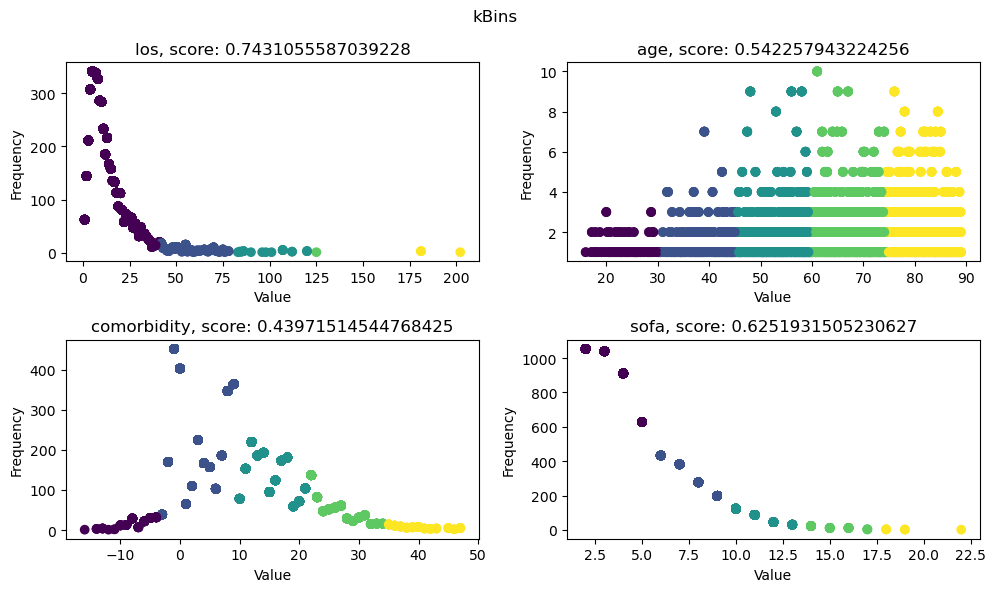

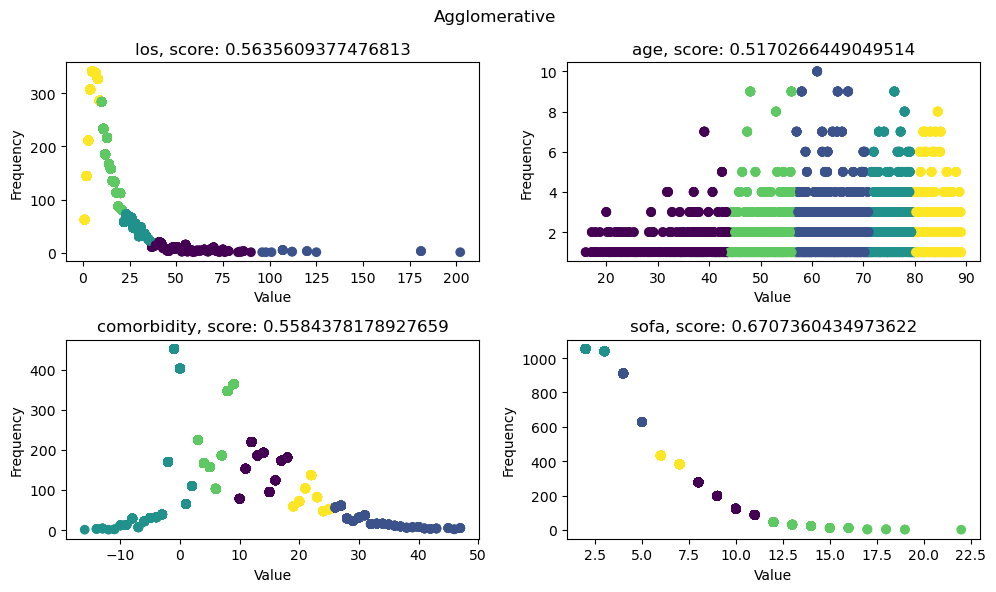

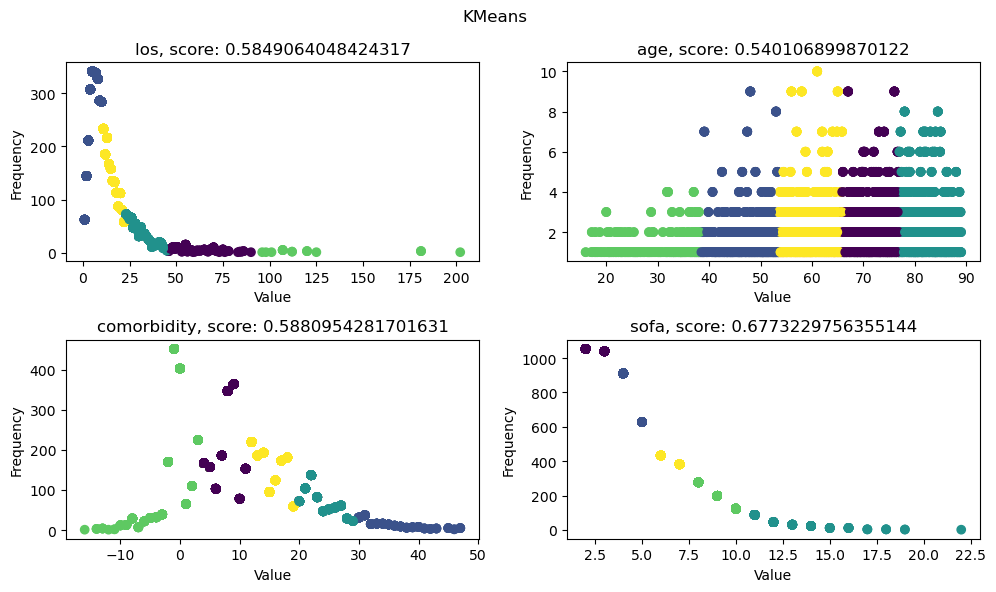

In [116]:
for type in categorisationTypes:

    df = categorisationTypes[type]

    fig = plt.figure(figsize=(10,6), dpi=100)

    fig.suptitle(f"{type}")

    for idx, col in enumerate(dataNeedingEncodingDF.columns):

        score = silhouette_score(np.asarray(dataNeedingEncodingDF[col]).reshape(-1,1), df[col])

        plt.subplot(2, 2, idx+1)
        plt.scatter(dataNeedingEncodingDF[col], dataNeedingEncodingDF[col].map(dataNeedingEncodingDF[col].value_counts()), c=df[col])
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        plt.title(f"{col}, score: {score}")

    plt.tight_layout()
    plt.show()

In [52]:
print(dataNeedingEncodingDF['sofa'].value_counts())

2     1054
3     1040
4      911
5      628
6      433
7      382
8      277
9      198
10     123
11      87
12      45
13      30
14      23
16      11
15      11
18       3
17       3
19       2
22       1
Name: sofa, dtype: int64


In [54]:
pd.set_option('display.max_rows', 1000)

In [56]:
categorisedDF.describe()

,los,age,comorbidity,sofa
count,5262.000000,5262.000000,5262.000000,5262.000000
mean,0.049601,2.840365,1.554922,0.385405
std,0.256471,1.064888,0.790029,0.643184
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,1.000000,0.000000
50%,0.000000,3.000000,1.000000,0.000000
75%,0.000000,4.000000,2.000000,1.000000
max,4.000000,4.000000,4.000000,4.000000


In [57]:
categories = {0: 'very_low', 1: 'low', 2: 'medium', 3: 'high', 4: 'very_high'}

encodedDF = categorisedDF.copy()

encodedDF[['respiration','coagulation','liver','renal','cardiovascular','cns']] = mimicDF[['respiration','coagulation','liver','renal','cardiovascular','cns']]

encodedDF

,los,age,comorbidity,sofa,respiration,coagulation,liver,renal,cardiovascular,cns
0,0.0,3.0,1.0,1.0,0.0,1.0,0.0,0.0,3.0,3.0
1,0.0,4.0,1.0,0.0,3.0,0.0,0.0,1.0,3.0,1.0
2,0.0,2.0,1.0,0.0,3.0,0.0,0.0,0.0,3.0,2.0
3,0.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,3.0,0.0
4,0.0,3.0,1.0,0.0,0.0,2.0,0.0,1.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...
5257,2.0,1.0,1.0,2.0,3.0,3.0,4.0,0.0,3.0,0.0
5258,0.0,2.0,2.0,0.0,3.0,0.0,0.0,0.0,3.0,1.0
5259,0.0,2.0,2.0,0.0,3.0,1.0,0.0,4.0,3.0,0.0
5260,0.0,3.0,0.0,0.0,1.0,2.0,0.0,0.0,3.0,0.0


In [58]:
for col in encodedDF.columns:
    encodedDF[col] = encodedDF[col].map(categories)

encodedDF['gender'] = mimicDF['gender'].map({0:'male', 1:'female'})

encodedDF = pd.get_dummies(encodedDF)

encodedDF.head()

,los_high,los_low,los_medium,los_very_high,los_very_low,age_high,age_low,age_medium,age_very_high,age_very_low,...,cardiovascular_medium,cardiovascular_very_high,cardiovascular_very_low,cns_high,cns_low,cns_medium,cns_very_high,cns_very_low,gender_female,gender_male
0,0,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
4,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [59]:
encodedDF.describe()

,los_high,los_low,los_medium,los_very_high,los_very_low,age_high,age_low,age_medium,age_very_high,age_very_low,...,cardiovascular_medium,cardiovascular_very_high,cardiovascular_very_low,cns_high,cns_low,cns_medium,cns_very_high,cns_very_low,gender_female,gender_male
count,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000,...,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000
mean,0.000190,0.037628,0.004181,0.000760,0.957241,0.354428,0.083048,0.211897,0.317560,0.033067,...,0.037818,0.096921,0.000190,0.075447,0.197453,0.088559,0.040099,0.598442,0.382554,0.617446
std,0.013786,0.190314,0.064531,0.027563,0.202333,0.478385,0.275981,0.408691,0.465571,0.178829,...,0.190775,0.295879,0.013786,0.264136,0.398115,0.284134,0.196210,0.490260,0.486057,0.486057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### TODO Do we want to standardise the data before categorising?

If another point (eg an outlier) is added to the dataset, then this could push the other points away from their original categorisation. Need outlier detection? 

In [60]:
print(encodedDF.columns)

Index(['los_high', 'los_low', 'los_medium', 'los_very_high', 'los_very_low',
       'age_high', 'age_low', 'age_medium', 'age_very_high', 'age_very_low',
       'comorbidity_high', 'comorbidity_low', 'comorbidity_medium',
       'comorbidity_very_high', 'comorbidity_very_low', 'sofa_high',
       'sofa_low', 'sofa_medium', 'sofa_very_high', 'sofa_very_low',
       'respiration_high', 'respiration_low', 'respiration_medium',
       'respiration_very_high', 'respiration_very_low', 'coagulation_high',
       'coagulation_low', 'coagulation_medium', 'coagulation_very_high',
       'coagulation_very_low', 'liver_high', 'liver_low', 'liver_medium',
       'liver_very_high', 'liver_very_low', 'renal_high', 'renal_low',
       'renal_medium', 'renal_very_high', 'renal_very_low',
       'cardiovascular_high', 'cardiovascular_medium',
       'cardiovascular_very_high', 'cardiovascular_very_low', 'cns_high',
       'cns_low', 'cns_medium', 'cns_very_high', 'cns_very_low',
       'gender_female', 

In [61]:
targetDF.describe()

,deathperiod
count,5262.000000
mean,0.896047
std,7.338713
min,-29.000000
25%,-1.000000
50%,-1.000000
75%,-1.000000
max,107.000000


In [62]:
targetDF

,deathperiod
0,-1
1,2
2,-1
3,-1
4,-1
...,...
5257,-1
5258,-1
5259,-1
5260,-1


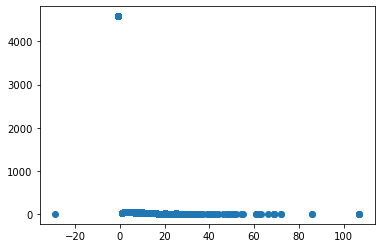

In [63]:
plt.scatter(targetDF['deathperiod'], targetDF['deathperiod'].map(targetDF['deathperiod'].value_counts()))
plt.show()

In [64]:
targetDF['deathperiod'] = targetDF['deathperiod'].apply(lambda x: x if x > -1 else -1)

In [65]:
targetDiedDF = targetDF[targetDF['deathperiod'] > -1]
targetNoDeathDF = targetDF[targetDF['deathperiod'] == -1].apply(lambda x: x+1.0)

In [66]:
targetDiedDF.shape

(678, 1)

In [67]:
targetNoDeathDF.shape

(4584, 1)

In [68]:
bins = 3

est = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
targetCategorisedDF = pd.DataFrame(data=est.fit_transform(targetDiedDF), columns=['deathperiod'])

targetCategorisedDF['deathperiod'] = targetCategorisedDF['deathperiod'].apply(lambda x: x + 1)

targetCategorisedDF.set_index(targetDiedDF.index, inplace=True)

targetCategorisedDF.head()


,deathperiod
1,1.0
7,1.0
16,1.0
36,1.0
40,1.0


In [69]:
targetNoDeathDF.head()

,deathperiod
0,0.0
2,0.0
3,0.0
4,0.0
5,0.0


In [70]:
combinedTargetDF = pd.concat([targetCategorisedDF, targetNoDeathDF], axis=1)

withDeath = combinedTargetDF.iloc[:,0]
noDeath = combinedTargetDF.iloc[:,1]

newTargetDF = withDeath.fillna(noDeath)

newTargetDF

0       0.0
1       1.0
2       0.0
3       0.0
4       0.0
       ... 
5257    0.0
5258    0.0
5259    0.0
5260    0.0
5261    0.0
Name: deathperiod, Length: 5262, dtype: float64

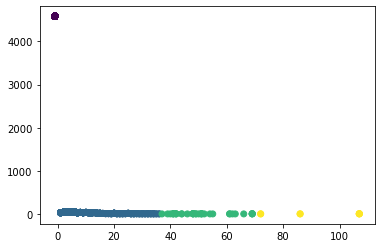

In [78]:
plt.scatter(targetDF['deathperiod'], targetDF['deathperiod'].map(targetDF['deathperiod'].value_counts()), c=newTargetDF)
plt.show()

### Here without the -1 value so we can see the variance of the rest

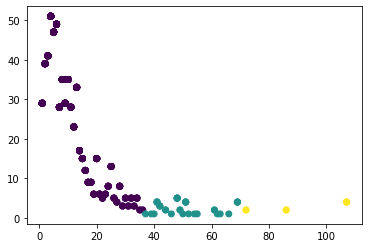

In [81]:
tempDF = targetDF[targetDF['deathperiod'] > -1]

plt.scatter(tempDF['deathperiod'], tempDF['deathperiod'].map(tempDF['deathperiod'].value_counts()), c=newTargetDF[newTargetDF> 0])
plt.show()

In [300]:
stackedTargetDF = np.stack(newTargetDF)

In [301]:
encodedDF

,los_high,los_low,los_medium,los_very_high,los_very_low,age_high,age_low,age_medium,age_very_high,age_very_low,...,cardiovascular_medium,cardiovascular_very_high,cardiovascular_very_low,cns_high,cns_low,cns_medium,cns_very_high,cns_very_low,gender_female,gender_male
0,0,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
4,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5257,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
5258,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
5259,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
5260,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [302]:

data = encodedDF.to_numpy()

target = stackedTargetDF


scorer = Scorer(data, target)

scorer.score()

tensor(1.3916, grad_fn=<AddBackward0>)
tensor(1.3563, grad_fn=<AddBackward0>)
tensor(1.3193, grad_fn=<AddBackward0>)
tensor(1.2873, grad_fn=<AddBackward0>)
tensor(1.2493, grad_fn=<AddBackward0>)
tensor(1.2020, grad_fn=<AddBackward0>)
tensor(1.1562, grad_fn=<AddBackward0>)
tensor(1.1130, grad_fn=<AddBackward0>)
tensor(1.0638, grad_fn=<AddBackward0>)
tensor(1.0114, grad_fn=<AddBackward0>)
tensor(0.9552, grad_fn=<AddBackward0>)
tensor(0.8972, grad_fn=<AddBackward0>)
tensor(0.8486, grad_fn=<AddBackward0>)
tensor(0.7970, grad_fn=<AddBackward0>)
tensor(0.7401, grad_fn=<AddBackward0>)
tensor(0.6928, grad_fn=<AddBackward0>)


c:\Users\benma\OneDrive\Kings\Modules\Term 2\Individual Project\LEN Individual Project\Static\LEN_Scorer.py:50: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  clip_grad_norm_(model.parameters(), 5)


tensor(0.6481, grad_fn=<AddBackward0>)
tensor(0.6108, grad_fn=<AddBackward0>)
tensor(0.5809, grad_fn=<AddBackward0>)
tensor(0.5571, grad_fn=<AddBackward0>)
tensor(0.5375, grad_fn=<AddBackward0>)
tensor(0.5180, grad_fn=<AddBackward0>)
tensor(0.5036, grad_fn=<AddBackward0>)
tensor(0.4907, grad_fn=<AddBackward0>)
tensor(0.4803, grad_fn=<AddBackward0>)
tensor(0.4723, grad_fn=<AddBackward0>)
tensor(0.4626, grad_fn=<AddBackward0>)
tensor(0.4529, grad_fn=<AddBackward0>)
tensor(0.4445, grad_fn=<AddBackward0>)
tensor(0.4367, grad_fn=<AddBackward0>)
tensor(0.4312, grad_fn=<AddBackward0>)
tensor(0.4234, grad_fn=<AddBackward0>)
tensor(0.4195, grad_fn=<AddBackward0>)
tensor(0.4149, grad_fn=<AddBackward0>)
tensor(0.4117, grad_fn=<AddBackward0>)
tensor(0.4087, grad_fn=<AddBackward0>)
tensor(0.4078, grad_fn=<AddBackward0>)
tensor(0.4065, grad_fn=<AddBackward0>)
tensor(0.4043, grad_fn=<AddBackward0>)
tensor(0.4036, grad_fn=<AddBackward0>)
tensor(0.4025, grad_fn=<AddBackward0>)
tensor(0.4014, grad_fn=<A